# Modeling the Interior of a Star: A Case Study of the Sun


# Motivation

The interior of stars is a complex and dynamic system that is challenging to study directly. I aim to model the interior of a star using parameters and functions provided in class. Specifically, I will focus on modelling the Sun, as we have been provided with the necessary constants and parameters in our coursework. The purpose of this notebook is to demonstrate the process of modelling the interior of the Sun and to provide insights into its structure and behavior.







## Part 1: Creating Functions to Compute Necessary Parameters
The first section of the code primarily consists of functions that calculate parameters required for modelling stellar interiors. These functions are designed to be easily integrated into larger computational models. The parameters calculated by these functions include the opacity, energy generation rate and the density of the stellar interior. The functions utilize the equations and constants provided in relevant literature.


### Importing Packages and Setting Constants

In [188]:
#import necessary packages
import pandas as pd
import numpy as np
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
import math
from scipy.integrate import solve_ivp
from scipy import optimize
from matplotlib import pyplot as plt

In [189]:
# Setting Constants

#General
G = 6.67259e-8 # cm^3/g/s^2
sb = 5.67051e-5 # erg cm^-2 K^-4 s^-1
c = 2.99792458e10 # cm/s

# Stellar Constants
M = 1.989e+33 # solar mass
Rs = 6.96e10 # cm
Ls = 3.826e33 #

# Mass Fractions
X = 0.7
Y = 0.28
Z = 0.02

# Constants for energy generation rate
k_B = 1.380658e-16  # Boltzmann constant (erg/K)
m_H = 1.6738e-24 # Mass of a hydrogen atom in g
a = 7.5646e-15 # 4*sb/c
N_A = 6.02214076e23 # Avogadro's number

# Assuming complete ionization and Z << 1, taken from Stellar Physics text:
mu_e = 2 / (1 + X)
mu_I = 4 / (1 + 3*X)

mu = (mu_I*mu_e) / (mu_I + mu_e)

# Define mass increment
m_r = M*1e-9

### Opacity
This function reads in an existing opacity table obtained from the OPAL website: <https://opalopacity.llnl.gov/>. The values in the table headers are given in terms of R and T, while the bulk of the table provides opacity values at a specific radius and temperature.

The table and its values are first interpolated using the date from the excel file. To adapt the code to the table values, input density ($\rho$) is first converted into radius log$R$. Ranges are set to log$T$ and log$R$ to ensure that table values are not being exceeded. 

In [190]:
# Path to OPAL opacity file
opacity_file = '/Users/swethasankar/Downloads/stellarModeling_solarOpacityTable.xlsx'

In [191]:
# Read in the opacity table from the .xlsx file
opacity_table = pd.read_excel(opacity_file, header=0, index_col=0)

# Identify appropriate values for logR, logT, and opacity from table
logR = opacity_table.columns.values.astype(float) 
logT = opacity_table.index.values.astype(float)
opacity = opacity_table.values.astype(float)


interpolator = RegularGridInterpolator((logT, logR), opacity)

def interpolate_opacity_table(density, temperature): 
        
    # Check if input is out of range
    log_T = np.log10(temperature)
    if density <= 0. :
        log_rho = 3 * log_T - 18 - 8. 
    else :
        log_rho = np.log10(density)
    
    # Convert input density to logR so it can be fed to interpolator
    logR_setting = log_rho - (3 * log_T) + 18
    
    # Make sure input is within bounds
    logR_setting = np.maximum(logR_setting, -8.)
    logT = np.maximum(log_T, 3.75)
    
    opacity = 10**(interpolator([logT, logR_setting])[0])
        
    return opacity


### Energy Generation Rate

The energy generation rate from hydrogen fusion takes into account several parameters, including density ($\rho$) in $g$ $cm^{-3}$, temperature ($T$) in $K$, hydrogen mass fraction ($X$), and metal mass fraction ($Z$).

The equations used in the following function are sourced from Chapter 18 of Stellar Structure and Evolution (Second Edition). The values of $\psi$, $\xi$, and $z1z2$ are also taken from the text and are used as constants throughout the function.

In [193]:
def energy_generation_rate(rho, T):
    
    T9 = T / 1e9 # temperature in 10^9 K
    T7 = T / 1e7 # temperature in 10^7 K
    psi = 1.5 # correction factor for the reaction rate
    
    xi = 1. 
    z1z2 = 1.  
    
    f11 = 5.92e-3 * z1z2 * ((rho*xi)/(T7**3))**(1./2) # shielding factor for the proton-proton reaction
    g11 = 1. + 3.82*T9 + 1.51*(T9**2) + 0.144*(T9**3) + 0.0114*(T9**4) 
    g_141 = 1. - 2.00*T9 + 3.41*(T9**2) -2.43*(T9**3)
    
    X_C = 0.1733*Z
    X_N = 0.0532*Z
    X_O = 0.4823*Z
    
    X_CNO = X_C + X_N + X_O
    
    e_pp = 2.57e4*psi*f11*g11*(X**2)*rho*(T9**(-2/3))*math.exp(-3.381/T9**(1./3))
    e_cno = 8.24e25 * g_141 * X_CNO * X * rho * T9**(-2./3) * math.exp(-15.231*T9**(-1./3) - (T9/0.8)**(2))
    
    e_tot = e_pp + e_cno
    
    return e_tot


### Density

Given the pressure $P$, temperature $T$, and composition $X$ and assuming complete ionization, we calculate the density (including the effect of radiation pressure and ideal gas pressure) in $g$ $cm^{-3}$.

The Pressure equation used is:
$P$ = $P_{g} + P_{rad}$, 
where $P_{g}$ = $\frac{\rho N_{A} kT}{\mu m_{H}}$ and $P_{rad}$ = $\frac{1}{3}$ $aT^{4}$.

Rearranging and solving for $\rho$, we find:
$\rho$ = $(P - P_{g})$$\frac{\mu}{N_{A} kT}$. 



In [194]:
# Solving for density using ideal gas and radiation pressure 
def density_from_pressure(P, T):
        return np.maximum(0., (P/T - ((a * T**(3.)) / 3.) )* ((mu) / (N_A * k_B)) )
                                    

### Temperature Gradients

The following equations for the adiabatic and convective temperature gradients are taken from the Stellar Physics text.

In [195]:
# This function calculates the radiative temperature gradient
def del_rad(m, l, P, T) :
    
    rho = density_from_pressure(P, T)  
    
    return 3*P*interpolate_opacity_table(rho, T)*l/ (16*np.pi*a*c*T**4*G*m)


In [196]:
# This function calculates teh adiabatic temperature gradient
def del_convec(P, T) :
    rho = density_from_pressure(P, T)    
    beta = ((rho*N_A*k_B*T)/mu) / P
    
    return 2 * (4 - 3*beta) / (32 - 24*beta -3*beta**2) # from equation 3.111 in the text


## Part 2: Setting Initial Conditions

### Near Center

For stellar modeling, I use the shooting method, which is described in the <http://numerical.recipes/book/book.html>, which requires both outward integrations and inward integrations.  

A point slightly away from the stellar center is chosen to set these conditions as singularities occur at m = r = 0. Thus, we use taylor expansions for $P_{init}$ and $T_{init}$, which were derived in session 18 during class. The $r_{init}$ and $l_{init}$ are general known equations for the stellar interior. I find the need to only specify Pc and Tc as the rest of the initial conditions can be derived from those parameters.


1.  $P_{init}$ = $P_{c}$ $-$ $\frac{3G}{8\pi}$ $\times$ $\frac{4\pi\rho_{c}}{3}^{\frac{4}{3}}$ $\times$  $m_{r}^{\frac{2}{3}}$

2.  $T_{init}$ = ( $T_{c}^{4} - \frac{1}{2ac} \times \frac{3}{4\pi}^{\frac{2}{3}} \times \kappa_{c} \epsilon_{c} \rho_{c}^{\frac{4}{3}}m_{r}^{\frac{2}{3}} )^{\frac{1}{4}}$

3.  $r_{init}$ = $(\frac{3m_{r}}{4\pi\rho_{c}})^{\frac{1}{3}}$ 

4. $l_{init}$ = $\epsilon m_{r}$

In [197]:
# Setting initial guesses for integrating from the center of the star outwards
def load1(Pc, Tc):
    
    rho_c = density_from_pressure(Pc, Tc)
    epsilon_c = energy_generation_rate(rho_c, Tc)
    opacity_c = interpolate_opacity_table(rho_c, Tc)
    
    l_in = epsilon_c * m_r
    r_in = ((3 * m_r) / (4 * np.pi * rho_c))**(1./3)
    
    
    # I assume a radiative core for the low mass ZAMS star chosen and pick a point near the stellar center
    # Taylor expansion is required
    T_in = (Tc**4 - 1./(2*a*c) * (3./(4*np.pi))**(2./3) * 
              opacity_c * epsilon_c * rho_c**(4./3) * m_r**(2./3))**(1./4)
    
    P_in = Pc - ((3 * G) / (8 * np.pi)) * ((4 * np.pi)/(3 * rho_c))**(4/3) * m_r**(2/3)
    
    return [r_in, l_in, P_in, T_in]


### Near Surface

Assuming the envelope extends to infinity, we cannot set the surface conditions for the star equal to 0 (i.e $P$ = 0 and $T$ = 0). Instead we assume the eddington approximation at a layer slightly below the surface of the star, where $\tau=\frac{2}{3}$. The value of $\tau=\frac{2}{3}$ is significant because it corresponds to the point in the star where the optical depth is just large enough to cause most of the visible light to be absorbed or scattered, but not so large that the star appears completely opaque. This depth can be taken as the photosphere, and it is the layer of the star where most of the visible light that we observe is emitted. Similar to above, I only find the need to specify two parameters, $R$ and $L$, which can be used to derive the other initial conditions. The functions used are given below:

1. $P_{surf} = \frac{GM}{R^{2}}\int_{0}^{\tau} \frac{1}{\kappa(\rho, T)} d\tau$ 
2. $T_{surf} = \frac{3}{4}T_{eff}(\tau + \frac{2}{3})$
3. $r_{surf} = R$
4. $l_{surf} = L$



In [198]:
def calculate_temperature(T_eff, tau):
    return T_eff * (3./4 * (tau + 2./3))**(1./4)

# Define a function to calculate the change in pressure as a function of optical depth tau and pressure P
def calculate_dP(R, M, G, interpolate_opacity_table, T):
    
    def dP(tau, P):
        # Calculate the density from pressure and temperature
        density = density_from_pressure(P, T(tau))
        # Interpolate the opacity value from a table using the density and temperature
        opacity = interpolate_opacity_table(density, T(tau))
        
        # Calculate the change in pressure using the opacity value
        return ((G * M) / R**2) * 1. / opacity
    
    return dP


def load2(R, L):
    # Calculate the effective temperature
    T_eff = (L / (4 * np.pi * R**2 * sb))**(1./4)

    # Define a function to calculate the pressure at the photosphere
    def calculate_pressure_at_photosphere(R, M, G, interpolate_opacity_table, T, tau_photos):
        sol = solve_ivp(calculate_dP(R, M, G, interpolate_opacity_table, T), [0, tau_photos], [0])
        return sol.y[0][-1]

    # Set the value of tau at the photosphere to 2/3
    tau_photos = 2./3
    
    # Calculate the pressure and temperature at the photosphere
    P_surf = calculate_pressure_at_photosphere(R, M, G, interpolate_opacity_table, 
                                               lambda tau: calculate_temperature(T_eff, tau), tau_photos)
    T_surf = calculate_temperature(T_eff, tau_photos)

    return [R, L, P_surf, T_surf]

## Part 3: Defining Integration Functions

The following function takes the independent variable $m$ and the dependent variables $P,$ $l,$ $r,$ and $T$ and returns the derivatives $\frac{dP}{dm}, \frac{dl}{dm}, \frac{dr}{dm},$ and $\frac{dT}{dm}$ in the form of ordinary differential equations (ODEs). 

In [199]:
#dPdm
def dP_dm(m, r):
    return (-G*m)/(4*np.pi*r**4)

#drdm
def dr_dm(r, rho):
    return 1/(4*np.pi*r**2*rho)

#define temperature gradient at all points of the star
def delta(m, l, P, T):
    rad_del = del_rad(m, l, P, T)
    del_ad = del_convec(P, T)
    
    if rad_del <= del_ad:
        return True, rad_del
    else:
        return False, del_ad

# setting functions for integration    
def derivs(m, soln_arr) :
    r, l, P, T = soln_arr
    
    rho = density_from_pressure(P, T)
    
    dldm = energy_generation_rate(rho, T)
    drdm = dr_dm(r, rho)
    dPdm = dP_dm(m, r)
    
    val, nabla = delta(m, l, P, T)
    
    dTdm = (-G*m*T*nabla) /(4*P*np.pi*r**4)
        
    return [drdm, dldm, dPdm, dTdm]

## Part 4: Integrating from Center to Surface and Surface to Center

### Setting Parameters

The initial guess for the Sun was based on the constant density model. However, this guess was significantly different from the actual values of the Sun and failed to converge. This outcome confirms that the constant density model is not an accurate representation of the Sun. 

For this code, guesses closer to the known values of the Sun's central pressure and temperature were set instead.

In [200]:
# Initial guesses for the values for the Sun - note that this code is very sensitive to these guesses
init_guessR = Rs 
init_guessL = Ls 
init_guessPc = 2.65e17#2e17
init_guessTc = 1.5e7#2e7

# Constant density model guess

#ctd_Pcguess = 3/(8*np.pi) * (G*M**2)/init_guessR**4 
#ctd_Tcguess = G*M*mu/(2*init_guessR*N_A*k_B) 

first_guess = [init_guessR, init_guessL, init_guessPc, init_guessTc]
#first_guess = [init_guessR, init_guessL, ctd_Pcguess, ctd_Pcguess]

In [201]:
# Setting parameters to run integration
shooting_frac = 0.2
nsteps = 1000
bound = shooting_frac * M 

### Integrating

The function 'shootf' performs integration in two directions: from the center of the Sun outwards and from the surface of the Sun inwards. It takes into account the specified boundary conditions and initial values.

In [202]:
def solve_outward_segment(Pc, Tc):
    t_eval = np.linspace(m_r, bound, 500) # to smooth the curve

    return solve_ivp(derivs, [m_r, bound], load1(Pc, Tc), t_eval = t_eval)

def solve_inward_segment(R, L):
    t_eval = np.linspace(M, bound, 500)
    return solve_ivp(derivs, [M, bound], load2(R, L), t_eval=t_eval)


def shootf(x):
    
    R, L, Pc, Tc = x
    out_int = solve_outward_segment(Pc, Tc)
    in_int = solve_inward_segment(R, L)
    return out_int, in_int

Convergence is assessed by calculating the difference between the endpoints of the integration. If this difference is zero, the code has converged. If the difference is non-zero, it indicates that the initial conditions need to be adjusted and the code should be rerun.

In [203]:
# Calculate the loss for each dimension of the solution
def calculate_loss(out_int, in_int):
    outint_final = out_int.y[:, -1]
    inint_final = in_int.y[:, -1]
    diff = 2 * (outint_final - inint_final) / (outint_final + inint_final)
        
    return diff

In [204]:
# Plot the results for luminosity
def plot_results(out_int, in_int, title, subplot_index):
    plt.subplot(2, 2, subplot_index)
    plt.plot(out_int.t/M, out_int.y[1]/Ls, c='indianred', linestyle='-', label='Outward Integration')
    plt.plot(in_int.t/M, in_int.y[1]/Ls, c='skyblue', linestyle='-', label='Inward Integration')
    plt.legend()
    plt.ylabel('l/L$_\odot$', fontsize=14)
    plt.xlabel('m/M$_\odot$', fontsize=14)
    plt.axvline(x=0.2, linestyle='--', color='black')
    plt.title('({}) {}'.format(chr(96+subplot_index), title), fontsize=14)

    
counter = 0
# Solves the boundary value problem and iterates until convergence 
def iterate(x):
    global counter
    counter += 1

    out_int, in_int = shootf(x)
    loss = calculate_loss(out_int, in_int)


    # Plot functions at iterations as a sanity check
    
    # Plot initial guess
    if counter == 1:
        fig = plt.figure(figsize=(12, 10))
        plot_results(out_int, in_int, "1 Iterations", 1)

    # Plot intermediate results
    if counter == 5:
        plot_results(out_int, in_int, "5 Iterations", 2)

    if counter == 10:
        plot_results(out_int, in_int, "10 Iterations", 3)
    
    # Plot converged results
    if counter == 18:
        plot_results(out_int, in_int, "18 Iterations", 4)
        plt.tight_layout()
        plt.show()
    
    return loss


## Part 5: Running and Plotting Results

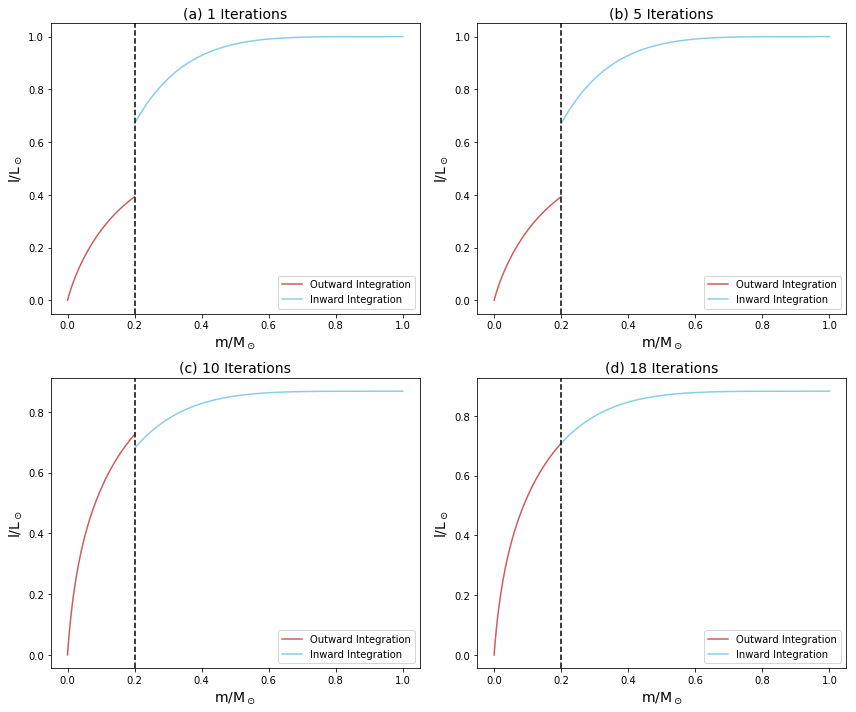

In [205]:
soln = optimize.root(iterate, first_guess)
out_int, in_int = shootf(soln.x) #final converged functions
out_guess, in_guess = shootf(first_guess) # run at initial conditions

In [206]:
# check the number of integrations run before convergence
print('Number of Iterations Until Convergence: ')
print(counter)

Number of Iterations Until Convergence: 
19


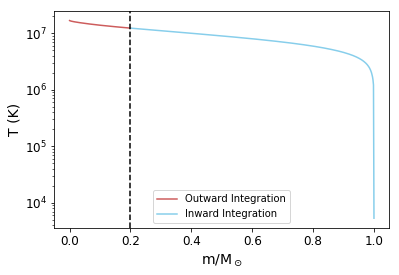

In [207]:
# Plot example of converged function for temperature

plt.plot(out_int.t / M, out_int.y[3], c='indianred', linestyle='-',  label='Outward Integration')
plt.plot(in_int.t/M, in_int.y[3] , c='skyblue', linestyle='-', label='Inward Integration')
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.yscale('log')
plt.ylabel('T (K)', fontsize=14) 
plt.xlabel('m/M$_\odot$', fontsize=14)
plt.axvline(x=0.2, linestyle='--', color='black')

In [208]:
import mesa_reader as mr

# load LOG directory
fname = mr.MesaLogDir('/Users/swethasankar/mesa-r22.11.1/tutorial/LOGS')
prof_data = fname.profile_data()

In [223]:
'''def plot_solns(out, inw, fig=None, ax=None, linestyle='-', log=False, checkMesa = False):
    
    if fig is None:
        fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    labels = ['r/R$_\odot$', 'l/L$_\odot$', 'P (dyne cm$^{-2}$)', 'T (K)']
    
    MESA_vals = [prof_data.R, prof_data.R, prof_data.P, prof_data.T]
    y_values_out = [out.y[0]/Rs, out.y[1]/Ls, out.y[2], out.y[3]]
    y_values_inw = [inw.y[0]/Rs, inw.y[1]/Ls, inw.y[2], inw.y[3]]
    
    for i, ax_sub in enumerate(ax):
        ax_sub.plot(out.t/M, y_values_out[i], c='darkturquoise', linestyle=linestyle)
        ax_sub.plot(inw.t/M, y_values_inw[i], c='darkturquoise', linestyle=linestyle)
        
        if checkMesa:
            ax_sub.plot(out.t/M, y_values_out[i], c='darkturquoise', linestyle=linestyle)
            ax_sub.plot(inw.t/M, y_values_inw[i], c='darkturquoise', linestyle=linestyle)
            ax_sub.set_ylabel(labels[i], fontsize=14)
            ax_sub.plot(prof_data.mass, MESA_vals[i], c='brown', linestyle=linestyle, label='MESA Model')
            plt.legend()
            
        ax_sub.set_ylabel(labels[i], fontsize=14)
        ax_sub.tick_params(axis='both', which='major', labelsize=12)
        if i == 2 and log:
            ax_sub.set_yscale('log')
        if i == 3:
            ax_sub.set_xlabel('m/M$_\odot$', fontsize=14)
    
    fig.canvas.draw()
    return fig, ax'''

def plot_solns(out, inw, fig=None, ax=None, linestyle='-', log=False, checkMesa=False):
    if fig is None:
        fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    labels = ['r/R$_\odot$', 'l/L$_\odot$', 'P (dyne cm$^{-2}$)', 'T (K)']

    MESA_vals = [prof_data.R, prof_data.R, prof_data.P, prof_data.T]
    y_values_out = [out.y[0]/Rs, out.y[1]/Ls, out.y[2], out.y[3]]
    y_values_inw = [inw.y[0]/Rs, inw.y[1]/Ls, inw.y[2], inw.y[3]]

    for i, ax_sub in enumerate(ax):
        ax_sub.plot(out.t/M, y_values_out[i], c='darkturquoise', linestyle=linestyle)
        ax_sub.plot(inw.t/M, y_values_inw[i], c='darkturquoise', linestyle=linestyle)

        if checkMesa:
            ax_sub.plot(prof_data.mass, MESA_vals[i], c='brown', linestyle=linestyle, label='MESA Model')
            ax_sub.plot(out.t/M, y_values_out[i], c='darkturquoise', linestyle=linestyle, label='This Work')
            ax_sub.plot(inw.t/M, y_values_inw[i], c='darkturquoise', linestyle=linestyle)
            if i == 0:
                ax_sub.legend()

        ax_sub.set_ylabel(labels[i], fontsize=14)
        ax_sub.tick_params(axis='both', which='major', labelsize=12)
        if i == 2 and log:
            ax_sub.set_yscale('log')
        if i == 3:
            ax_sub.set_ylabel('m/M$_\odot$', fontsize=14)

    fig.canvas.draw()
    return fig, ax



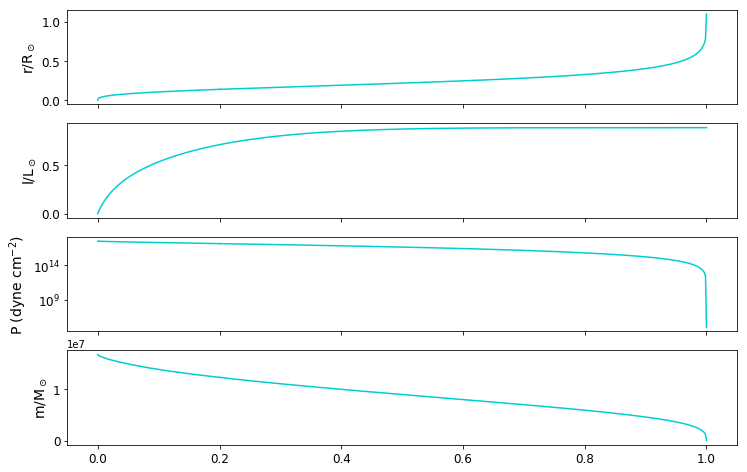

In [224]:
fig, ax = plot_solns(out_int, in_int, log=True)


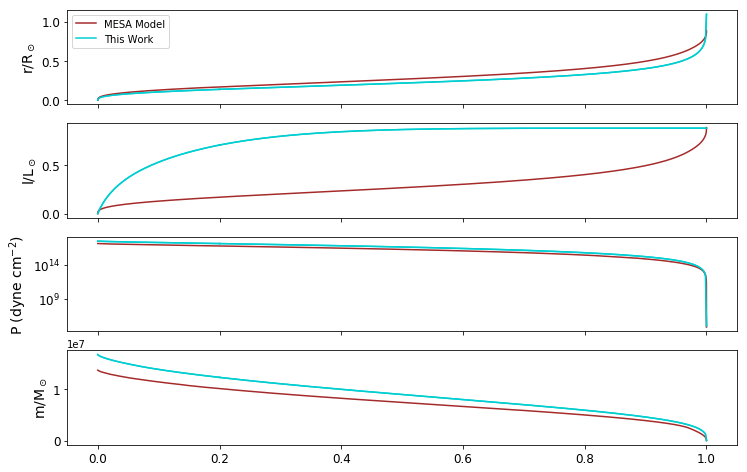

In [225]:
# CHANGE MESA's model from accessing radius to luminosity before rerunning
fig, ax = plot_solns(out_int, in_int, checkMesa=True, log=True) 

### Creating LaTeX Table with Values

In [227]:
# define function to check if shell is radiative or convective at a mass coordinate
def radOrconv(m, l, P, T):
    val, nabla = delta(m, l, P, T)
    return 'Convective' if val else 'Radiative'

#access all values from convergent solution
mass_all = np.concatenate((out_int.t, in_int.t[::-1])).tolist()
rad_all = np.concatenate((out_int.y[0], in_int.y[0][::-1])).tolist()
lum_all = np.concatenate((out_int.y[1], in_int.y[1][::-1])).tolist()
press_all = np.concatenate((out_int.y[2], in_int.y[2][::-1])).tolist()
temp_all = np.concatenate((out_int.y[3], in_int.y[3][::-1])).tolist()


# calculate each parameter at each mass coordinate based off of converged solution
rho_conv = [density_from_pressure(press_all[i], temp_all[i]) for i in range(0, 1000)]
epsilon_conv = [energy_generation_rate(rho_conv[i], temp_all[i]) for i in range(0, 1000)]
opacity_conv = [interpolate_opacity_table(rho_conv[i], temp_all[i]) for i in range(0, 1000)]
ad_conv = [del_convec(press_all[i], temp_all[i]) for i in range(0, 1000)]
radCon = [radOrconv(mass_all[i], lum_all[i], press_all[i], temp_all[i]) for i in range(0, 1000)]

dlnT = np.gradient(np.log(temp_all))
dlnP = np.gradient(np.log(press_all))

temp_grad = dlnT / dlnP #do we instead use -(r^2 P)/ (G m rho) (1/T) (dT/dr)?
 

In [245]:
# Shorten number of mass coordinates to 20 to input into latex

# Determine the step size for slicing
step_size = len(mass_all) // 20

# Shorten the lists using list slicing
short_mass_coord = mass_all[::step_size]
m_values = [i / M for i in short_mass_coord]

short_rad = rad_all[::step_size]
r_values = [i / Rs for i in short_rad]

short_lum = lum_all[::step_size]
l_values = [i / Ls for i in short_lum]

press_values = np.log(press_all[::step_size])
temp_values = np.log(temp_all[::step_size])

# Shorten the remaining lists based on the shortened mass coordinate list
rho_values = [rho_conv[i] for i in range(0, len(rho_conv), step_size)]
energy_values = [epsilon_conv[i] for i in range(0, len(epsilon_conv), step_size)]
opacity_values = [opacity_conv[i] for i in range(0, len(opacity_conv), step_size)]
del_ad_values = [ad_conv[i] for i in range(0, len(ad_conv), step_size)]
radCon_values = [radCon[i] for i in range(0, len(radCon), step_size)]
temp_grad_values = [temp_grad[i] for i in range(0, len(radCon), step_size)]

#print(r_values)

In [255]:
#convert lists to a latex readable table
from tabulate import tabulate

# Create the table headers and data
headers = ['m (solar mass fraction - m/M)', 'rho', 'r (solar radius fraction - r/R)',
           'l (solar luminosity fraction l/Ls)', 'P', 'T', 'Energy Generation Rate',
           'Opacity', 'Del_ad', 'Nature of the Shell']

data = list(zip(m_values, rho_values, r_values, l_values, press_values, temp_values, energy_values,
                opacity_values, del_ad_values, temp_grad_values, radCon_values))
column_headings = ['m', '$\rho$', 'r',
           'l', 'P', 'T', '$\epsilon$',
           '$\kappa$', '$\Delta_{ad}$', 'Nature of the Shell']

# Add vertical line before the first column heading
column_headings[0] = '| ' + column_headings[0]

# Generate the table body
table = tabulate(data, headers=column_headings, tablefmt='latex', floatfmt='.2f')

# Add deluxetable environment formatting
table = '\\begin{deluxetable*}{|c|cccccccccc|}\n\\tablecaption{Your Table Caption}\n\\tablewidth{\\textwidth}\n\\tablehead{\\colhead{} & \\colhead{m (solar mass fraction - m/M)} & \\colhead{rho} & \\colhead{r (solar radius fraction - r/R)} & \\colhead{l (solar luminosity fraction l/Ls)} & \\colhead{P} & \\colhead{T} & \\colhead{energy generation rate} & \\colhead{opacity} & \\colhead{del_ad} & \\colhead{temp gradient} & \\colhead{convective/radiative nature}}\n\\startdata\n' + table + '\n\\enddata\n\\end{deluxetable*}'

# Print the table
print(table)

\begin{deluxetable*}{|c|cccccccccc|}
\tablecaption{Your Table Caption}
\tablewidth{\textwidth}
\tablehead{\colhead{} & \colhead{m (solar mass fraction - m/M)} & \colhead{rho} & \colhead{r (solar radius fraction - r/R)} & \colhead{l (solar luminosity fraction l/Ls)} & \colhead{P} & \colhead{T} & \colhead{energy generation rate} & \colhead{opacity} & \colhead{del_ad} & \colhead{temp gradient} & \colhead{convective/radiative nature}}
\startdata
\begin{tabular}{rrrrrrrrrrl}
\hline
ho\$ &    r &     l &     P &     T &   \$\textbackslash{}epsilon\$ &   \$\textbackslash{}kappa\$ &   \$\textbackslash{}Delta\_\{ad\}\$ & Nature of the Shell   \\
\hline
 0.00 & 144.01 & 0.00 & 0.00 & 40.32 & 16.63 & 32.24 &         1.25 &       0.40 &            0.40 & Radiative             \\
 0.02 & 131.48 & 0.06 & 0.21 & 40.17 & 16.57 & 14.11 &         1.35 &       0.40 &            0.40 & Radiative             \\
 0.04 & 124.18 & 0.08 & 0.33 & 40.07 & 16.53 &  9.47 &         1.42 &       0.40 &            0.